# inference mode

In [1]:
import numpy as np
import glob
import PIL
import cv2
import sys ,os
import matplotlib.pyplot as plt
%matplotlib inline
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
import tensorflow as tf
import keras

/home/sdc/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
log_dir = '/home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/logs200/'
sys.path.append('/home/sdc/github/AdversarialVariationalBayes/')

In [3]:
ls -l /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/logs200/

总用量 2165104
-rw-rw-r-- 1 sdc sdc       757 11月 16 09:02 checkpoint
-rw-rw-r-- 1 sdc sdc   5294542 11月 15 20:42 events.out.tfevents.1510749229.frankwang-Tri01
-rw-rw-r-- 1 sdc sdc   6047335 11月 16 09:04 events.out.tfevents.1510749772.frankwang-Tri01
-rw-rw-r-- 1 sdc sdc   5712407 11月 15 20:42 graph.pbtxt
-rw-rw-r-- 1 sdc sdc 437272168 11月 16 08:22 model.ckpt-108458.data-00000-of-00001
-rw-rw-r-- 1 sdc sdc     12294 11月 16 08:22 model.ckpt-108458.index
-rw-rw-r-- 1 sdc sdc   2705272 11月 16 08:22 model.ckpt-108458.meta
-rw-rw-r-- 1 sdc sdc 437272168 11月 16 08:32 model.ckpt-110074.data-00000-of-00001
-rw-rw-r-- 1 sdc sdc     12294 11月 16 08:32 model.ckpt-110074.index
-rw-rw-r-- 1 sdc sdc   2705272 11月 16 08:32 model.ckpt-110074.meta
-rw-rw-r-- 1 sdc sdc 437272168 11月 16 08:42 model.ckpt-111681.data-00000-of-00001
-rw-rw-r-- 1 sdc sdc     12294 11月 16 08:42 model.ckpt-111681.index
-rw-rw-r-- 1 sdc sdc   2705272 11月 16 08:42 model.ckpt-111681.meta
-rw-rw-r-- 1 sdc sdc 437272168 11月 16 08:52 

### laod data

In [4]:
file_list = glob.glob('/data/dataset/torcs/tmpavbnotebook/*.jpg')

In [5]:
def np_show(a):
    plt.imshow(a)

def im_read(f):
    return plt.imread(f)

def im_show(f):
    np_show(im_read(f))

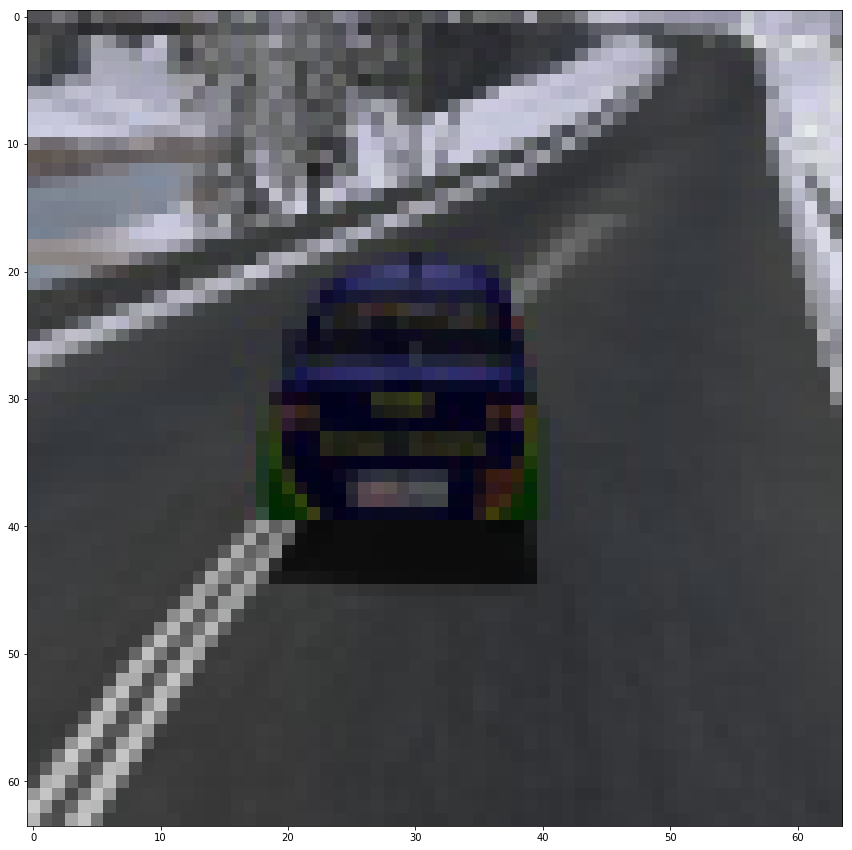

In [6]:
plt.figure(num=3, figsize=(18, 15),)
a = plt.imread(file_list[0])
a = cv2.resize(a,(64,64))
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
a = np.reshape(a , (1,) + a.shape)
#a = a/127.5 - 1.
plt.imshow(a[0])

In [7]:
src_img = np.asarray([   cv2.resize(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB),(64,64))/255.  for i in file_list[:16]])


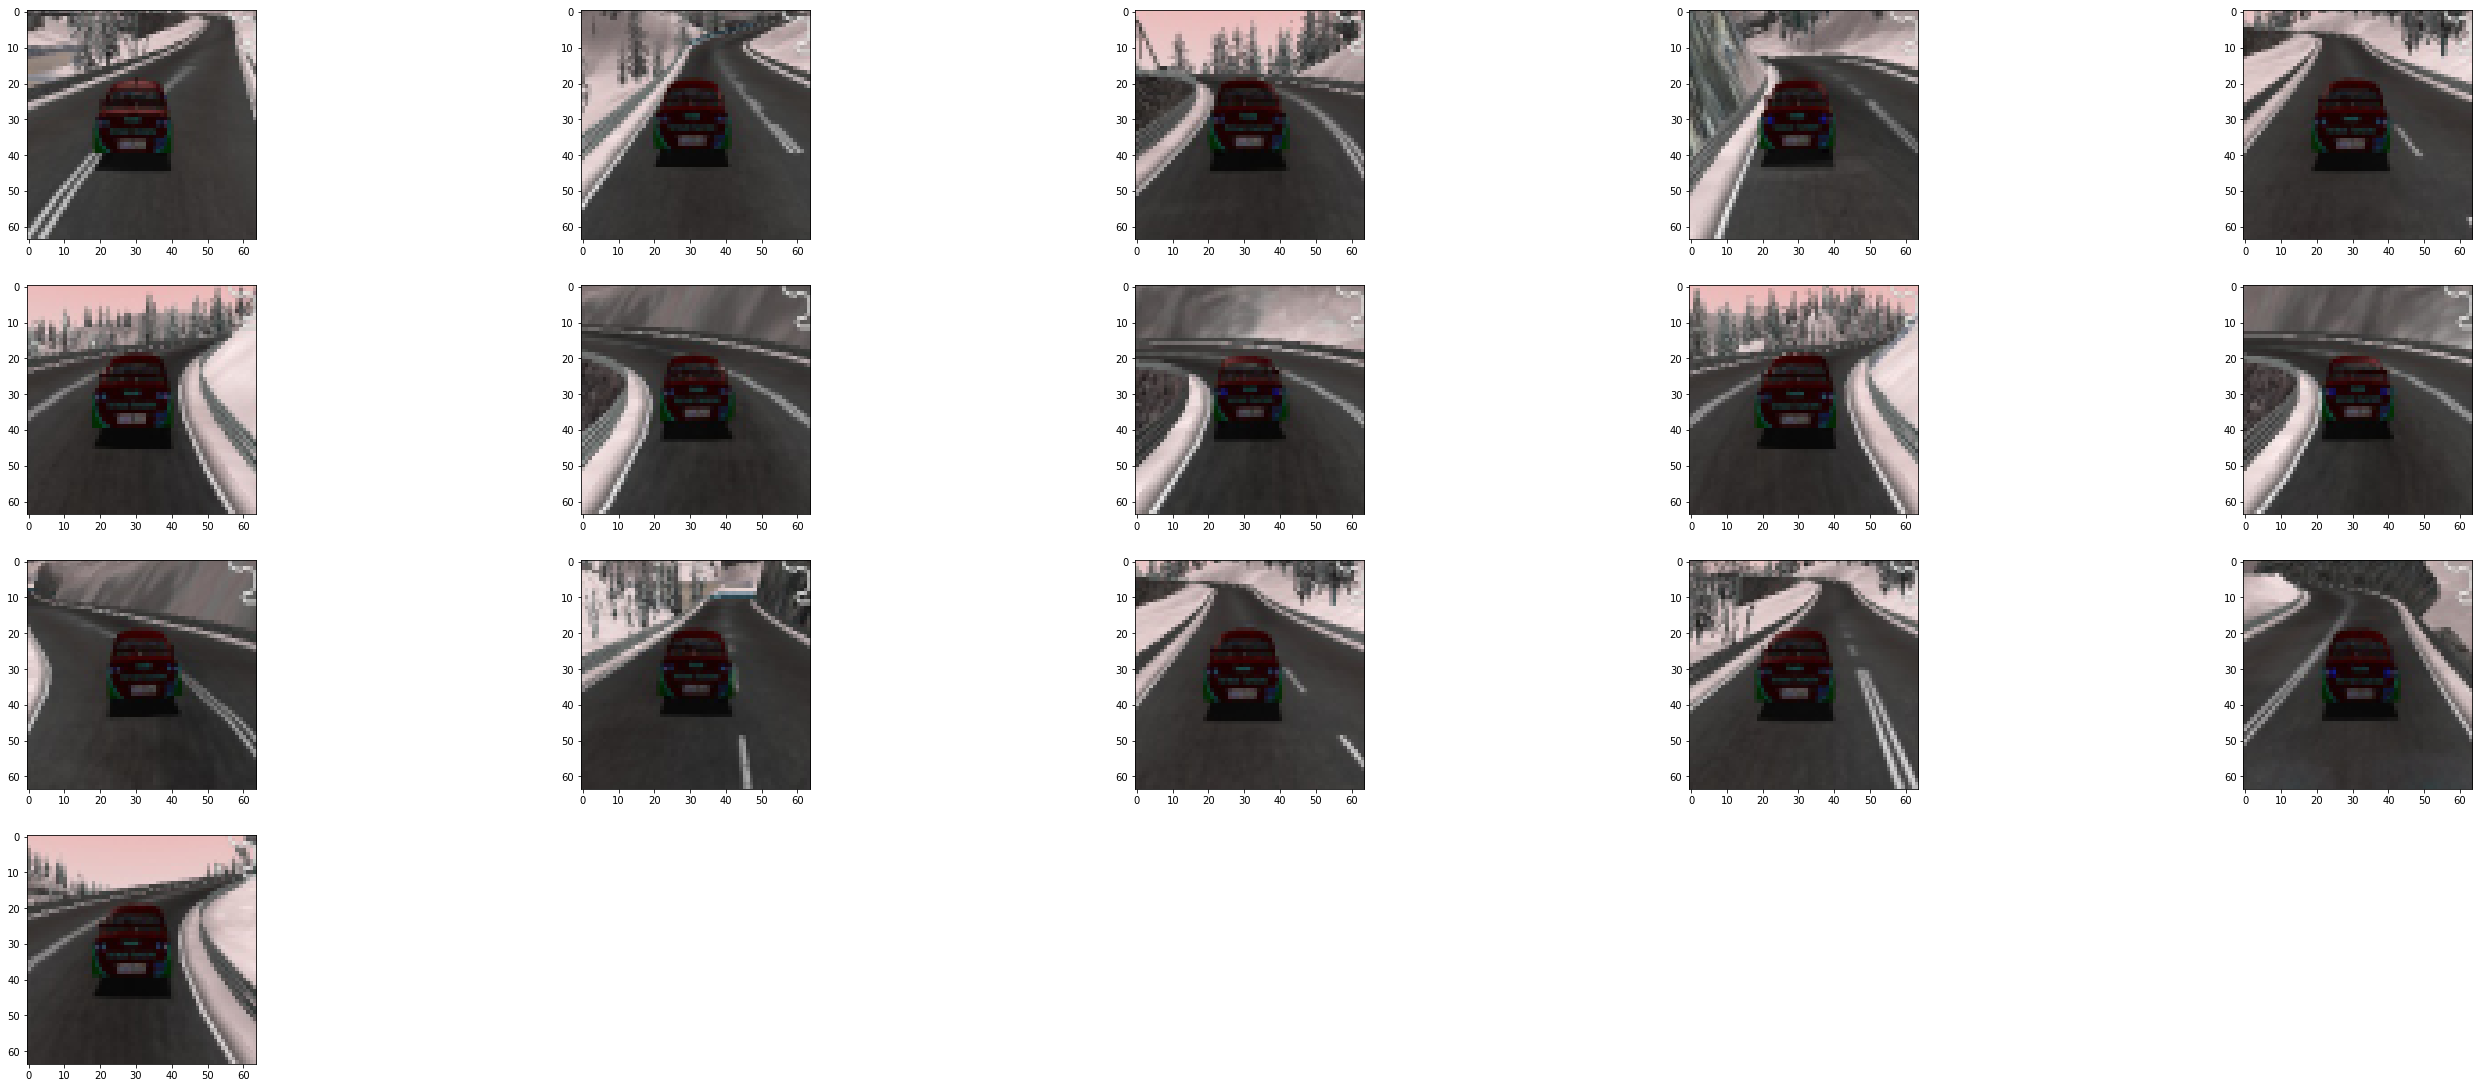

In [8]:
gen = 0.5*(src_img+1.)

plt.figure(num=3, figsize=(48, 75),)
for i in range(len(src_img)):
    plt.subplot(15,5,i+1)
    plt.imshow(src_img[i])

## load  model

####  设置环境变量，设置tf参数
#### 如果不启动tf session ，不用设置config

In [9]:
ckpt = tf.train.latest_checkpoint(log_dir)
model_path = ckpt+'.meta'

In [10]:
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True

In [11]:
#build model
from avb import inputs
from avb.decoders import get_decoder
from avb.avb.models import get_encoder, get_adversary
from avb.avb import AVB
from avb.decoders import get_reconstr_err, get_decoder_mean, get_interpolations
avb_config = {}
avb_config['gf_dim'] = 64
avb_config['df_dim'] = 64
avb_config['test_is_adaptive_eps'] = False
avb_config['dataset'] = 'torcs'
avb_config['encoder']= 'conv2'
avb_config['decoder']='conv2'
avb_config['adversary']='conv1'
avb_config['image_size']=128
avb_config['output_size']= 64
avb_config['c_dim']= 3
avb_config['z_dim']= 64
avb_config['z_dist']='gauss'
avb_config['cond_dist']= 'gauss'
avb_config['eps_dim'] = 0
avb_config['eps_nbasis']= 32
avb_config['is_ac'] = False
avb_config['output_size'] = 64

/home/sdc/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [12]:
decoder = get_decoder(avb_config['decoder'], avb_config) #conv2
encoder = get_encoder(avb_config['encoder'], avb_config) #conv2
adversary = get_adversary(avb_config['adversary'], avb_config) #conv1

x_train = tf.placeholder(shape=[None,64,64,3],dtype=tf.float32, name='trainx')
z_sampled = tf.random_normal([64, 64])

In [13]:
avb = AVB(encoder, decoder, adversary, x_train, z_sampled, avb_config, beta=1,is_training=True)

In [14]:
avb.decoder_out[0] ,avb.z_real

(<tf.Tensor 'decoder/x_0/BiasAdd:0' shape=(?, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'encoder/fully_connected/BiasAdd:0' shape=(?, 64) dtype=float32>)

#for empty graph
tf.reset_default_graph()

with tf.Session(config=config) as sess:

    # Restore graph
    saver = tf.train.import_meta_graph(model_path)

    saver.restore(sess, ckpt)

In [15]:
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
#saver = tf.train.import_meta_graph(model_path)
saver = tf.train.Saver()
saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/logs200/model.ckpt-114904


In [16]:
decode_out = get_decoder_mean(avb.decoder_out,None)

In [17]:
z_out = avb.z_real

In [18]:

feed_dict = {x_train : src_img}
decode2 ,z = sess.run([decode_out, z_out],feed_dict =feed_dict)

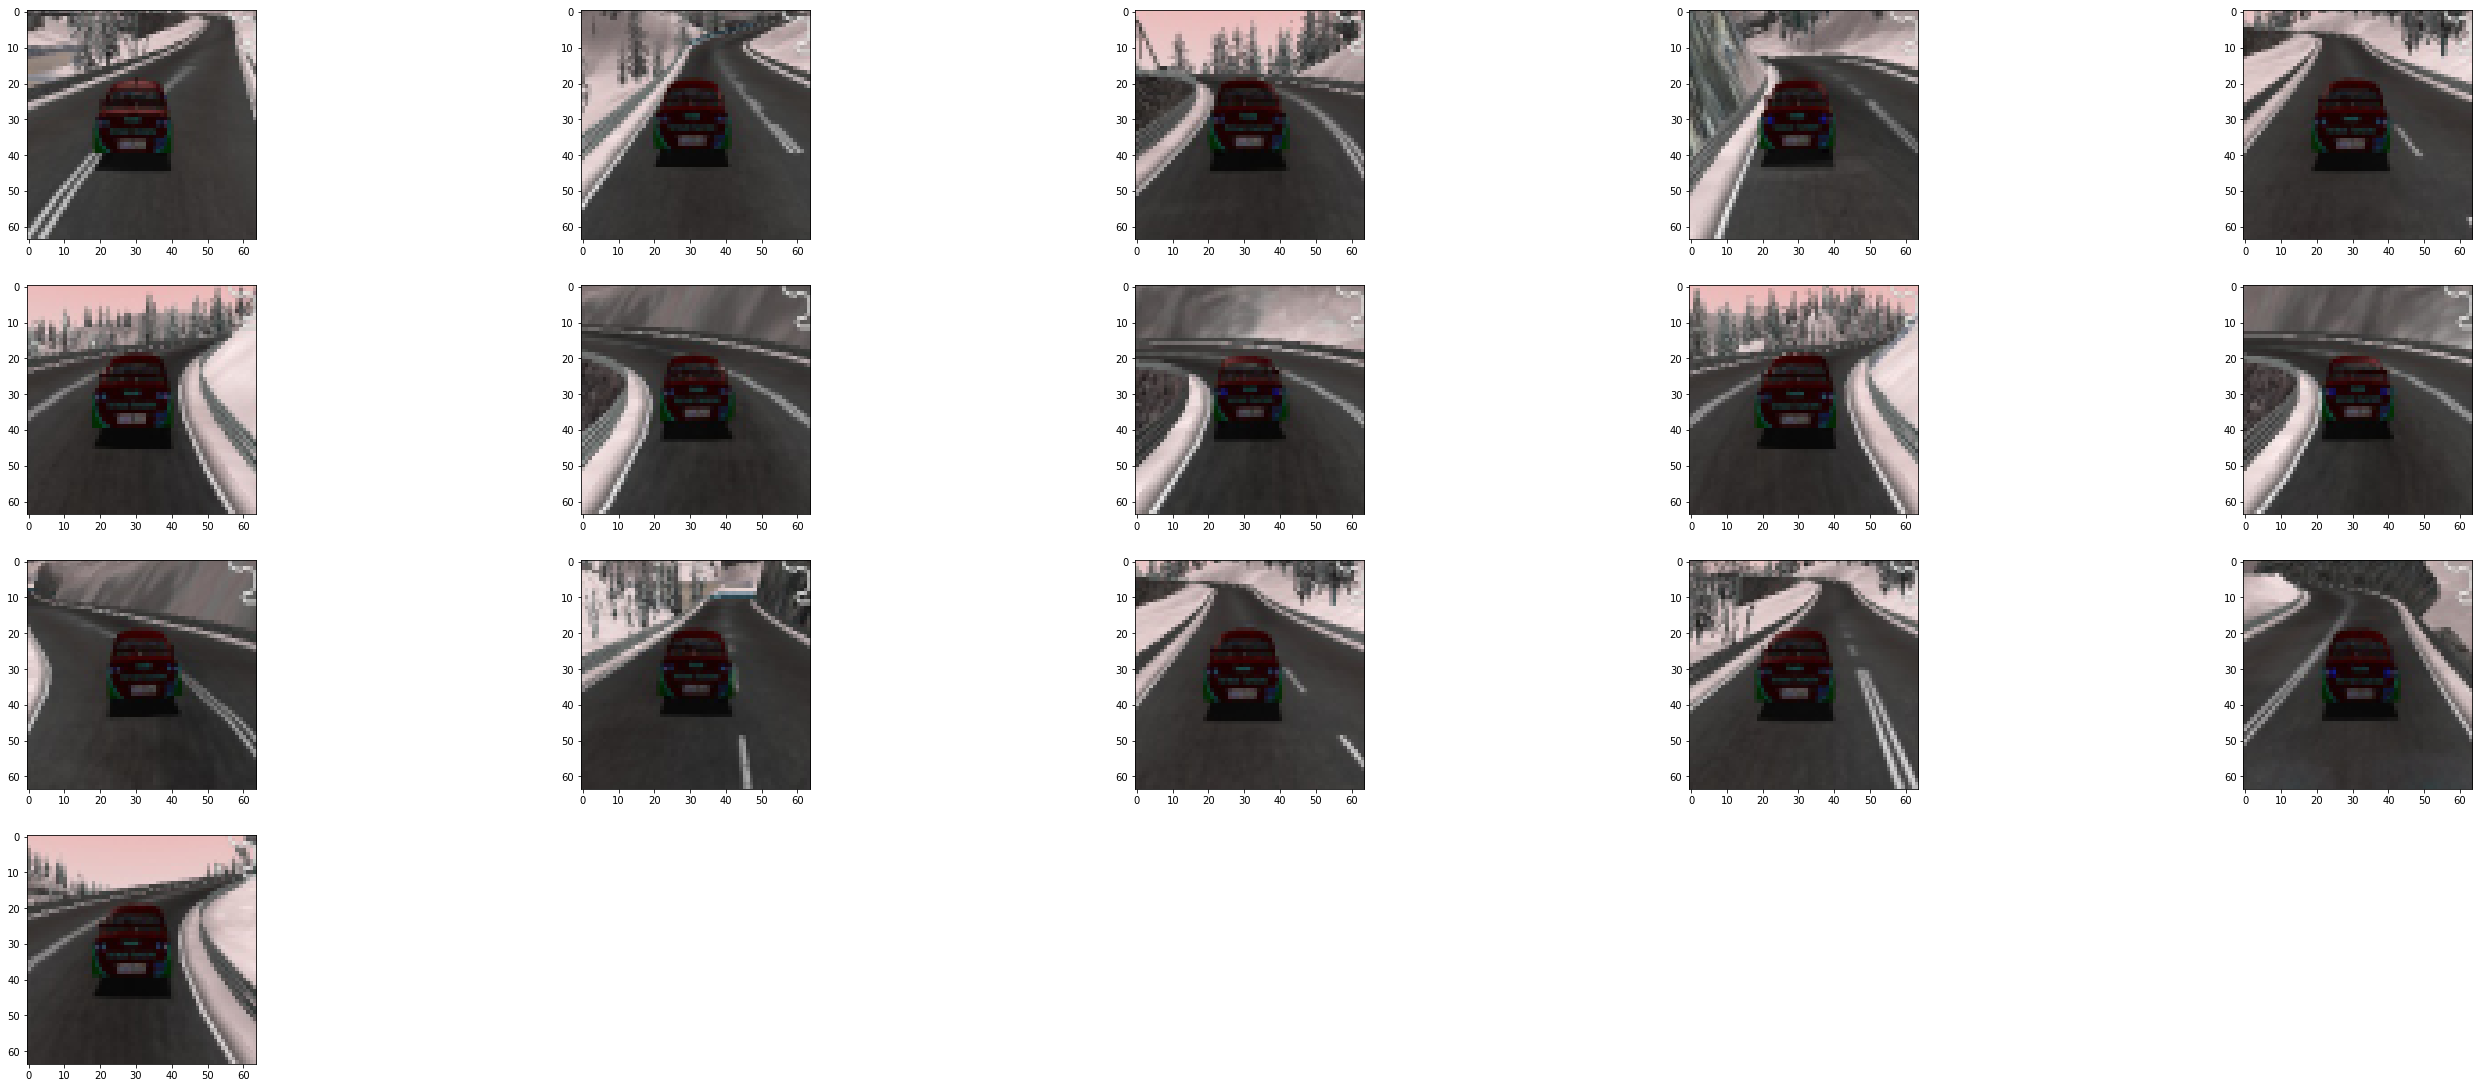

In [19]:
##原始图像
plt.figure(num=3, figsize=(48, 75),)
for i in range(len(src_img)):
    plt.subplot(15,5,i+1)
    plt.imshow(src_img[i])

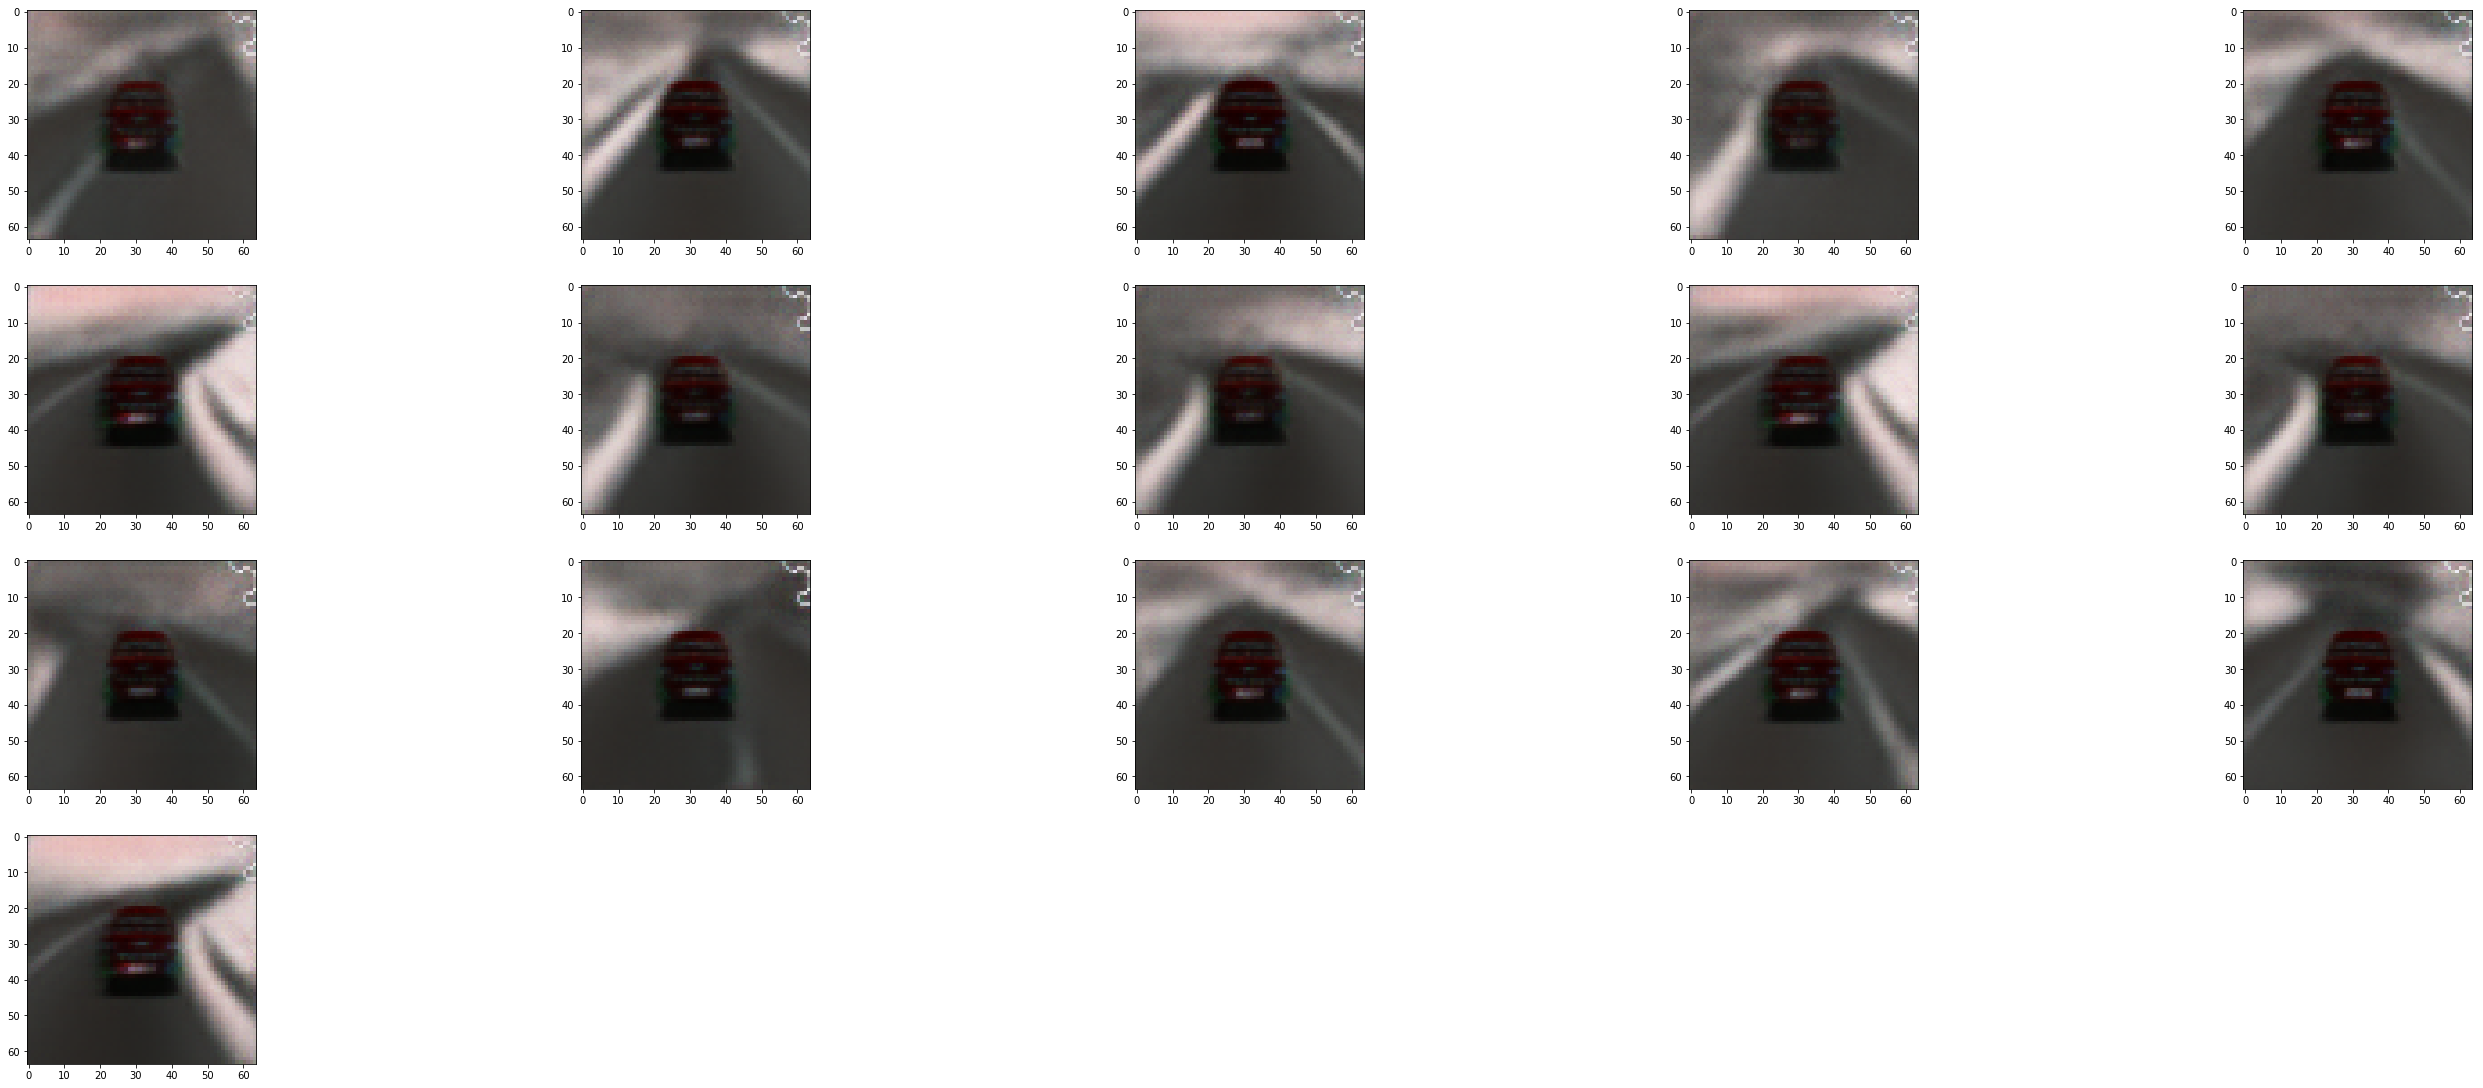

In [20]:
#decode生成
#plt.imshow(decode[1])
#plt.imshow(decode2[1])

plt.figure(num=3, figsize=(48, 75),)
for i in range(len(decode2)):
    plt.subplot(15,5,i+1)
    plt.imshow(decode2[i])

In [21]:
z1 = avb.z_real[:8]
z2 = avb.z_real[8:16]
x_interp = get_decoder_mean(get_interpolations(decoder, z1, z2, 8, avb_config), avb_config)

In [22]:
interp = sess.run(x_interp ,feed_dict=feed_dict)

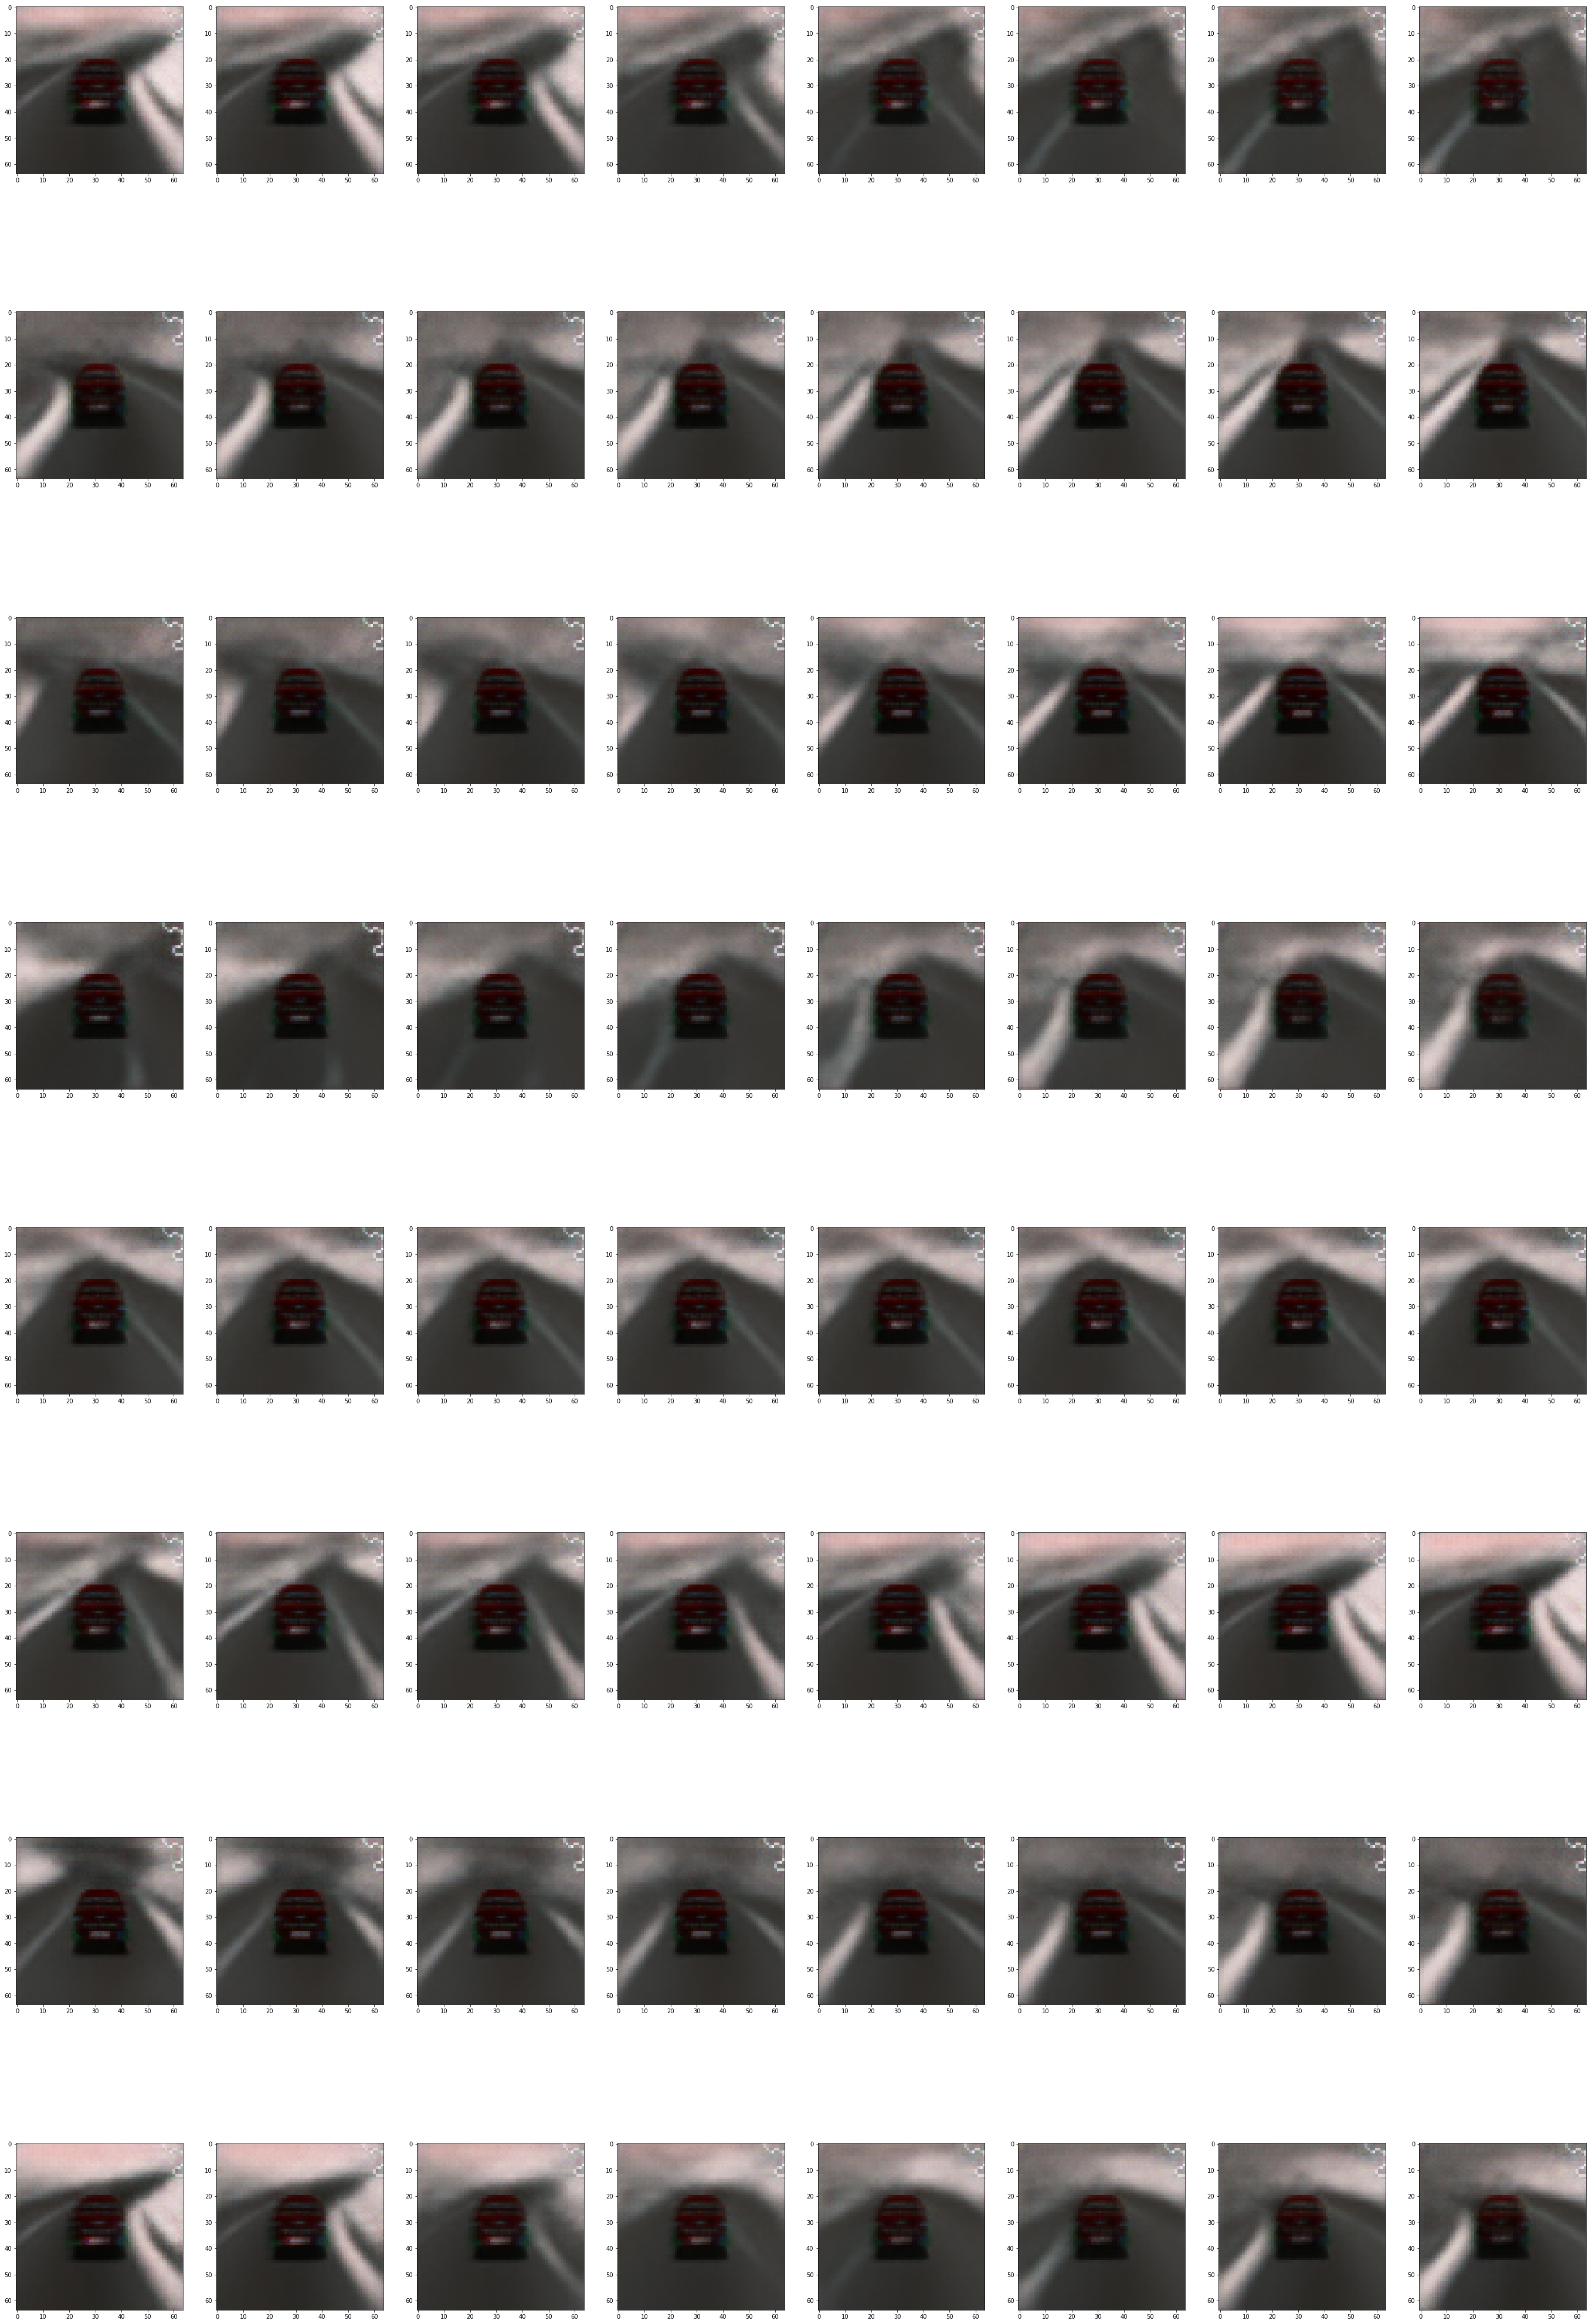

In [23]:
##自带插值
plt.figure(num=3, figsize=(48, 75),)
for i in range(len(interp)):
    plt.subplot(8,8,i+1)
    plt.imshow(interp[i])

In [24]:
def change(x, index = 0 , range_ = (0,1), n = 5):
    n = int(n)
    #print(n)
    x = np.repeat(x, n, 0)
    #print(x.shape)
    x[:,index] = x[:,index]+np.linspace(range_[0],range_[1],n)
    return x



In [25]:
def multi_chane(x, index = [0,1] , range_ = [(0,1),(2,3)], n = 5):
    all_c = []
    for i in range(len(index)):
        all_c.append(change(x, index[i],range_[i],n))
    all_c = np.concatenate(all_c)
    return all_c
                     

In [26]:
def plot(interp,n,index):
#     plt.title(i)
    for i in range(len(interp)):
        plt.title(index[i//n])
        plt.subplot(10,n,i+1)
        plt.imshow(interp[i])
       

In [27]:
def cvt_imgs(decode_img, N = 10,name = 'test.jpg'):
    size = decode_img.shape[0]

    big_img = np.ones([int(64 * size / n), int(64 * n), 3], np.float32)
    
    o_shape = [64, 64]
    for i in range(int(size / n))  :
        for j in range(N):
            addimg = decode_img[i * n + j][:]
            big_img[i * o_shape[0]:(i + 1) * o_shape[0], j * o_shape[1]:(j + 1) * o_shape[1]] = addimg
    #big_img = (big_img + 1.) * 255. / 2. #这里可能需要修改
    big_img = (big_img) * 255. 
    big_img_rgb = cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(name ,big_img_rgb )
    #return big_img_rgb

In [30]:
#plt.figure(num=3, figsize=(48, 75),)
num=64
#index = [i for i in range(30,40)]
#range_ = [ (-15,15) for  i in range(30,40)]
index = [i for i in range(num)]
range_ = [ (-25,25) for  i in range(num)]

n =30

x_ints = get_decoder_mean(decoder(z_out ), avb_config)

zints = multi_chane(z[12:13],index= index ,range_ = range_, n = n )
interp = sess.run(x_ints ,feed_dict={z_out:zints})

#plot(interp , n  ,index)
cvt_imgs(interp,n,name='beta-200-p13-r25---test24685.jpg')

In [45]:
interp.shape

(20, 64, 64, 3)